# FEEDSTOCK HOME ASSIGNMENT - 2

## Enron Email Dataset

The Enron Corpus is a database of emails generated by 158 employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

### Importing Libraries

In [255]:
import os, email
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string
import math

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

### Reading the .csv file containing the dataset

##### We will use a subset of 10000 rows for faster computation (nrows = 10000 )

In [34]:
emails = pd.read_csv('/Users/aravindmohan/Desktop/FeedStock/Dataset/emails_2.csv',nrows=10000)
print(emails.shape)
emails.head()

(10000, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


The shape of email shows 21 features below, since the code was ran again after modifying the dataset during reviewing

In [407]:
print(emails.shape)

(10000, 21)


#### get_text_from_email( ) : function to get only the body/content of the mail

#### split_email_addresses( ) : function to separate when multiple email addresses are found

In [187]:
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [427]:
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)

keys = messages[0].keys()
for key in keys:
    emails[key] = [doc[key] for doc in messages]

    
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))


# Split multiple email addresses
emails['From'] = emails['From'].map(split_email_addresses)
emails['To'] = emails['To'].map(split_email_addresses)


emails['user'] = emails['file'].map(lambda x:x.split('/')[0])
del messages

#emails.head(20)

"messages = list(map(email.message_from_string, emails['message']))\nemails.drop('message', axis=1, inplace=True)\n\nkeys = messages[0].keys()\nfor key in keys:\n    emails[key] = [doc[key] for doc in messages]\n\n    \n# Parse content from emails\nemails['content'] = list(map(get_text_from_email, messages))\n\n\n# Split multiple email addresses\nemails['From'] = emails['From'].map(split_email_addresses)\nemails['To'] = emails['To'].map(split_email_addresses)\n\n\nemails['user'] = emails['file'].map(lambda x:x.split('/')[0])\ndel messages\n\nemails.head(20)"

In [189]:
emails["content"].head()
#emails["content"].count()

0                            Here is our forecast\n\n 
1    Traveling to have a business meeting takes the...
2                       test successful.  way to go!!!
3    Randy,\n\n Can you send me a schedule of the s...
4                  Let's shoot for Tuesday at 11:45.  
Name: content, dtype: object

### Get the shape of DF, and display count of unique entries in each column 

In [190]:
print('shape of the dataframe:', emails.shape)
for col in emails.columns:
    print(col, emails[col].nunique())

shape of the dataframe: (10000, 21)
file 10000
Message-ID 10000
Date 5222
From 754
To 1295
Subject 3181
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 2
X-From 918
X-To 1741
X-cc 421
X-bcc 2
X-Folder 125
X-Origin 10
X-FileName 17
content 5271
user 6
Date_new_2 5222
year 5
month 12


### We need to separate month and year from 'Date' for analysis later

In [42]:
emails['Date']

0       Mon, 14 May 2001 16:39:00 -0700 (PDT)
1        Fri, 4 May 2001 13:51:00 -0700 (PDT)
2       Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
3       Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
4       Thu, 31 Aug 2000 05:07:00 -0700 (PDT)
                        ...                  
9995    Tue, 25 Jan 2000 02:31:00 -0800 (PST)
9996    Tue, 25 Jan 2000 02:15:00 -0800 (PST)
9997    Tue, 25 Jan 2000 01:36:00 -0800 (PST)
9998     Wed, 6 Dec 2000 06:03:00 -0800 (PST)
9999    Mon, 24 Jan 2000 08:36:00 -0800 (PST)
Name: Date, Length: 10000, dtype: object

In [47]:
emails['Date_new_2'] = pd.to_datetime(emails['Date'],utc=True)


In [48]:
emails['year']= emails['Date_new_2'].dt.year

In [51]:
emails['month']= emails['Date_new_2'].dt.month

[frozenset({'phillip.allen@enron.com'}),
 frozenset({'ina.rangel@enron.com'}),
 frozenset({'1.11913372.-2@multexinvestornetwork.com'}),
 frozenset({'messenger@ecm.bloomberg.com'}),
 frozenset({'aod@newsdata.com'}),
 frozenset({'critical.notice@enron.com'}),
 frozenset({'market-reply@listserv.dowjones.com'}),
 frozenset({'rebecca.cantrell@enron.com'}),
 frozenset({'webmaster@earnings.com'}),
 frozenset({'paul.kaufman@enron.com'}),
 frozenset({'yild@zdemail.zdlists.com'}),
 frozenset({'bounce-news-932653@lists.autoweb.com'}),
 frozenset({'public.relations@enron.com'}),
 frozenset({'stephanie.miller@enron.com'}),
 frozenset({'tracy.arthur@enron.com'}),
 frozenset({'sarah.novosel@enron.com'}),
 frozenset({'bobregon@bga.com'}),
 frozenset({'subscriptions@intelligencepress.com'}),
 frozenset({'tim.heizenrader@enron.com'}),
 frozenset({'rob_tom@freenet.carleton.ca'}),
 frozenset({'calxa@aol.com'}),
 frozenset({'ei_editor@ftenergy.com'}),
 frozenset({'billc@greenbuilder.com'}),
 frozenset({'fr

In [206]:
Check=emails['year'].unique().tolist()

In [208]:
print("Data is provided for the following years : {}".format(Check))

Data is provided for the following years : [2001, 2000, 1999, 1980, 2002]


## The "message" column is parsed into 16 new coulumns (and 3 columns for date - right end)

In [52]:
emails.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,...,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,Date_new_2,year,month
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,2001-05-14 23:39:00+00:00,2001,5
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,2001-05-04 20:51:00+00:00,2001,5
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2000-10-18 10:00:00+00:00,2000,10
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,2000-10-23 13:13:00+00:00,2000,10
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2000-08-31 12:07:00+00:00,2000,8


,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,...,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,Date_new_2,year,month
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,2001-05-14 23:39:00+00:00,2001,5
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,2001-05-04 20:51:00+00:00,2001,5


## Stemming, Lemmatizing and removing punctuations on the content/body of email  

In [75]:
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

In [76]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

## TF-IDF 

#### Term Frequency–Inverse Document Frequency is used to evaluate how important a word is to a document in a collection or corpus

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(emails["content"])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(10000, 56104)
['', '0', '00', '000', '0000', '000000', '00000000', '000000000000935', '000000000001282', '000000000009659', '000000000021442', '000000000041547', '000000000067320', '000000000069328', '000000000070920', '000000000076886', '000000000077129', '000000000077131', '000000000079824', '000000000079825', '00000788265', '0000105886', '00005', '00006', '000066', '0000ff', '0001', '00010', '00011', '000119', '0002', '00021579pdfpdf', '000221', '0003', '0004', '00044', '0004fonttdtd', '0005', '0006', '0007', '000711', '000714', '00079', '0008', '00080', '000817doc', '000822a', '000825', '0009', '000c05a6', '001', '0010', '0011', '0012', '0013', '0014', '0016', '0018', '001875', '001mmbtu', '001nevereditthisline002', '002', '0020', '0022', '00240833807905653', '0025', '0028', '003', '0030', '0031', '0033', '0033cc', '0034fonttdtd', '003660543', '003750', '004', '0040', '0044', '0046', '0047fonttdtd', '005', '0054fonttdtd', '005625', '0057fonttdtd', '005pm', '006', '006666', '007', 

In [78]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

,,0,00,000,0000,000000,00000000,000000000000935,000000000001282,000000000009659,...,zufferlienronenronxg,zufferlihouectect,zuidholland,zukav,zuniga,zurich,zuritahoueese,zwiebel,zyft02yahoocom,zzjaakkoahmalamorganstanleycom
0,0.295800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.031086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.141738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.016356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.073238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Checking for null values

In [83]:
data = X_tfidf_df.isnull().sum()/len(X_tfidf_df)*100
data

                                  0.0
0                                 0.0
00                                0.0
000                               0.0
0000                              0.0
                                 ... 
zurich                            0.0
zuritahoueese                     0.0
zwiebel                           0.0
zyft02yahoocom                    0.0
zzjaakkoahmalamorganstanleycom    0.0
Length: 56104, dtype: float64

### The below graph shows that the biggest spike in volume of mails sent was in the year 2000

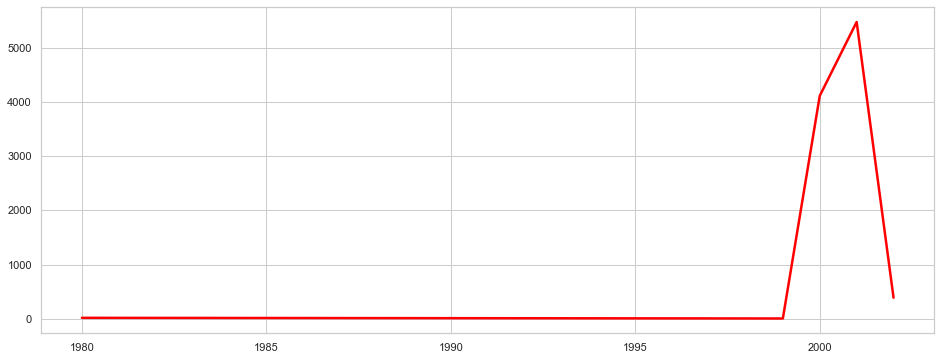

In [128]:
plt.figure(figsize=(16, 6))


sns.set(style="whitegrid")
sns.lineplot(data=emails.groupby(emails['year'])['content'].count(),color='red', linewidth=2.5)


In [418]:
emails.loc[emails['year'] == 2000].head(2)

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,...,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,Date_new_2,year,month
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2000-10-18 10:00:00+00:00,2000,10
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,...,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,2000-10-23 13:13:00+00:00,2000,10


### The below graph shows that during october the mails had the highest traffic. The fiscal year in USA (accounting period for the federal government) also goes on between October 1 and September 30 

Text(0, 0.5, 'No. of Emails')

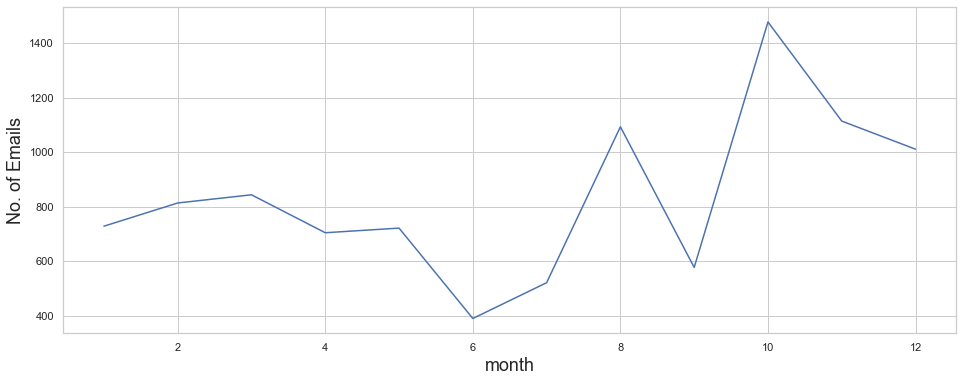

In [414]:
plt.figure(figsize=(16, 6))
ax = emails.groupby(emails['month'])['content'].count().plot()
ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('No. of Emails', fontsize=18)

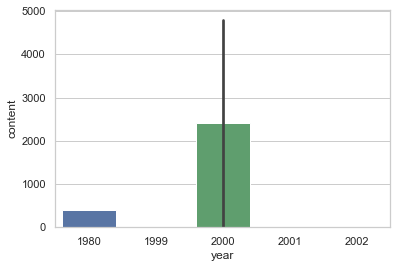

In [152]:
#plt.figure(figsize=(16, 6))


sns.set(style="whitegrid")
sns.barplot(x=emails['year'],y=emails.groupby(emails['year'])['content'].count())


In [155]:
sub_df = emails[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(9671, 3)
(8414, 3)


In [421]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
#sub_df.sort_values(by='count', ascending=False).head(20)

### Using TfidfVectorizer and PCA(Princile Component Analysis) to reduce the features to 2 dimentions

In [224]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(emails.content)

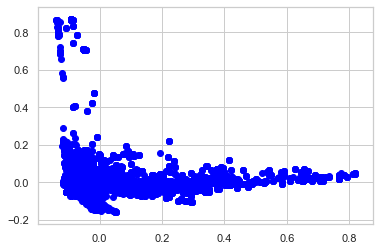

In [225]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='blue')
plt.show()

## Using K-means clustering. We are selecting K=3

In [226]:
clf = KMeans(n_clusters = 3, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

In [227]:
X_dense = X.todense()
pca = PCA(n_components = 2).fit(X_dense)
coords = pca.transform(X_dense)

## The graph shows 3 clusters in Red, Blue and Green selection. The Black Diamonds denote the centroid of each cluster

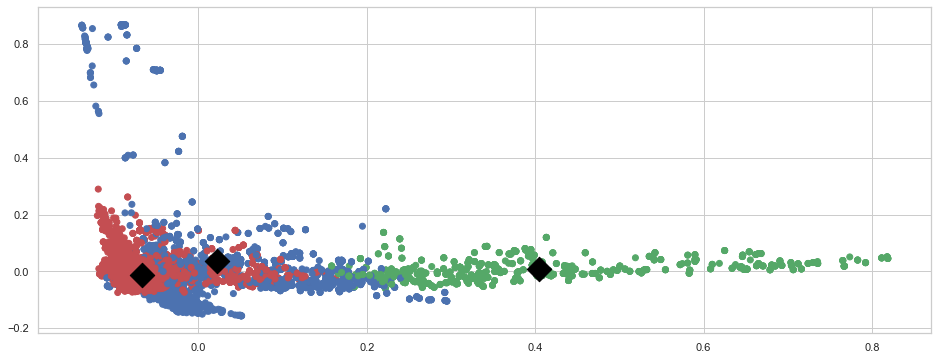

In [241]:
plt.figure(figsize=(16, 6))
label_colours = ['r', 'g', 'b']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='D', s=300, c='black')

In [243]:
X_tfidf_df.shape

(10000, 56104)

In [244]:
X_tfidf_df.iloc[:,106:].head(1)

,0100,0101,010101,01012001,0102,0102001,01022001,010222,0103,01032001,...,zufferlienronenronxg,zufferlihouectect,zuidholland,zukav,zuniga,zurich,zuritahoueese,zwiebel,zyft02yahoocom,zzjaakkoahmalamorganstanleycom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Using K-means clustering and fitting the model with the TFID vector made earlier 

### The following code took 30 minutes to run on the subset of the main dataset. Hence, due to time constraints, it was run only once with the set of parameters as written below

In [280]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=30, n_init=1, verbose=1)
model.fit(X_tfidf_df)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9747.8511881453
start iteration
done sorting
end inner loop
Iteration 1, inertia 9708.636524681924
start iteration
done sorting
end inner loop
Iteration 2, inertia 9697.64077548772
start iteration
done sorting
end inner loop
Iteration 3, inertia 9693.13347643741
start iteration
done sorting
end inner loop
Iteration 4, inertia 9691.619806629451
start iteration
done sorting
end inner loop
Iteration 5, inertia 9691.104179271619
start iteration
done sorting
end inner loop
Iteration 6, inertia 9690.899429064913
start iteration
done sorting
end inner loop
Iteration 7, inertia 9690.8223972081
start iteration
done sorting
end inner loop
Iteration 8, inertia 9690.770630605648
start iteration
done sorting
end inner loop
Iteration 9, inertia 9690.721383013451
start iteration
done sorting
end inner loop
Iteration 10, inertia 9690.704584406822
start iteration
done sorting
end inner loop
Iteration 11, inertia 96

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=30,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

In [282]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]


In [284]:
terms = vect.get_feature_names()

In [283]:
order_centroids


array([[33031,     0, 42229, ..., 16317, 24169, 34760],
       [41946, 33427,     0, ..., 55880, 25247, 32652],
       [37176, 40644,  5093, ..., 48868, 44995, 32321]])

In [311]:
model.cluster_centers_.argsort()


array([[34760, 24169, 16317, ..., 42229,     0, 33031],
       [32652, 25247, 55880, ...,     0, 33427, 41946],
       [32321, 44995, 48868, ...,  5093, 40644, 37176]])

In [424]:
order_centroids.shape

(3, 56104)

## The below graph shows "Frequency of words" in the datasets's subset of 1st 10,000 rows

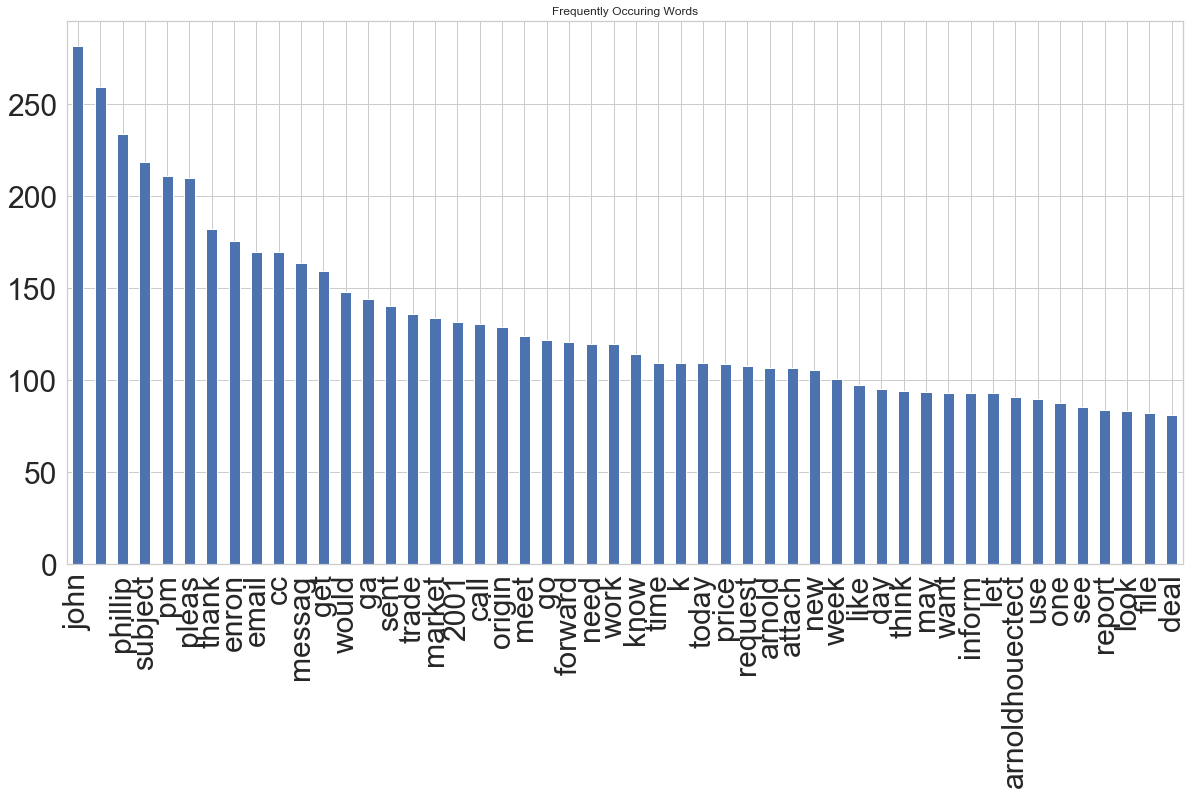

In [276]:
X_tfidf_df.sum().sort_values(ascending=False).head(50).plot(kind='bar',figsize=(20,10),fontsize=30,title='Frequency of Words');

## The below information shows the count of the word frequency

In [267]:
Display_X=X_tfidf_df.sum().sort_values(ascending=False)

In [425]:
Display_X.head(60).to_frame().apply(np.ceil)
#ceil is used to round off the value, since the numbers were appearing in decimals also. To be looked into why it happened.

,0
john,282.0
,260.0
phillip,234.0
subject,219.0
pm,211.0
pleas,210.0
thank,183.0
enron,176.0
email,170.0
cc,170.0


In [422]:
#Commenting the code due to bugs
#for i in range(true_k):
     #print('Cluster d:', i),
     #for ind in order_centroids[i,30 :]:
         #print(' ', terms[ind])

## The following codes are used to plot the frequency of each word sepeated by their cluster region

In [341]:
def top_terms(X, features, grp_ids = None, min_tfidf = 0.1, top_words = 25):
    if grp_ids:
        msgs = X[grp_ids].toarray()
    else:
        msgs = X.toarray()
    msgs[msgs < min_tfidf] = 0
    tfidf_means = np.mean(msgs, axis = 0)
    return top_tfidf_features(tfidf_means, features, top_words)

In [342]:
def top_words_per_cluster(X, y, features, min_tfidf = 0.1, top_words = 25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label) 
        features_df = top_terms(X, features, ids, min_tfidf = min_tfidf, top_words = top_words)
        features_df.label = label
        dfs.append(features_df)
    return dfs

In [345]:
def top_tfidf_features(row, features, top_words = 20):
    top_ids = np.argsort(row)[::-1][:top_words]
    top_features = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_features, columns=['features', 'score'])
    return df

In [402]:
def plot_top_words(dfs):
    fig = plt.figure(figsize = (11, 8), facecolor = "w")
    x = np.arange(len(dfs[0]))
    label_colours_2 = ['r', 'g', 'b']
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad = 16, fontsize = 13)
        ax.set_title("Cluster : " + str(df.label), fontsize = 15)
        ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (-2, 2))
        ax.barh(x, df.score, align = 'center', color = label_colours_2[i-1])
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1] + 1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(wspace = 1.5)
    plt.show()

In [403]:
tops = top_words_per_cluster(X, labels, terms, 0.1, 50)


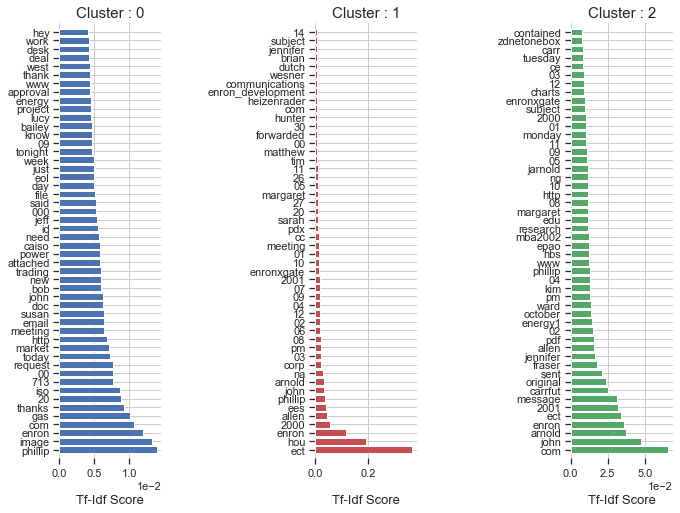

In [404]:
plot_top_words(tops)


###### In this particular subset:  Philip, Image, Enron, Thanks, Gas, are the most frequently used words in the emails

## End of Code

# Critical reflection on Assignment ( Aravind Mohan)

The Enrom dataset was a great learning curve. I had to get familier with NLP before getting on with the assignment.
I did research on the Enron Dataset and went through related blogs and few videos.

I went through the "NLP with Python for Machine Learning Essential Training" by Derek Jedamski in LinkedIn learning to dive into NLP. It contained hands-on problems in each section.
Link : https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/

Then, I went through Kaggle notebooks, GitHub, and blogs which had the Enron analysis topics. It gave an idea on tackling the problem. However, some functions were tricky when I tried and I had to reference them to get the correct parsing of the email message part.

The websites and notebooks I referenced to understand / replicate / modify to fit the problem are :

https://github.com/vinidixit/enron-nlp-mining

https://williamkoehrsen.medium.com/machine-learning-with-python-on-the-enron-dataset-8d71015be26d

https://github.com/adriancampos1/Enron_Email_Analysis

http://beneathdata.com/how-to/email-behavior-analysis/


